# Comparing forced and unforced OLR and TS trends from the CESM1-LE

__Jonah Shaw, 2022/04/25__

Observations show large increases in spring OLR despite the largest temperature increases occurring in the spring. We ask, is observed spring OLR consistent with variability present in the CESM1-LE?

Despite the OLR increases being concentrated in spectral bands heavily weighted towards the surface, we have to use broadband values if we want to compare with the model. This might muddy the signal if there is variability to do other climate processes (SSW events in the late winter).

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask,pd
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define functions

#### Let's focus on the central Arctic for now (70-90N)

### Load and process CERES observations.

I am using files from Brian Medeiros (most recent, somehow processed)

In [2]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)
ceres_files.sort()

In [3]:
# ceres_subset = arc_subset('%s/CERES_EBAF_Ed4.1_OLR_200003-202106.nc' % ceres_savedir,var='OLR')

ceres_ds = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202106.nc' % ceres_savedir)      
ceres_subset = ceres_ds['OLR'].sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))

ceres_ds.close()

Turn the CERES data into a timeseries

In [4]:
ceres_subset_wgtd = add_weights(ceres_subset) # add area-weighting coordinate
ceres_subset_spatavg = ceres_subset_wgtd.weighted(ceres_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])

ceres_subset.close()
ceres_subset_wgtd.close()
ceres_subset_spatavg.close()

### Load Berkeley BEST data

Berkeley Earth Surface Temperatures (BEST).

Haven't used this before. Was suggested by Jen/Dave.

http://berkeleyearth.org/data/

In [5]:
best_path = '/glade/work/jonahshaw/obs/BEST/'
best_file = 'Land_and_Ocean_LatLong1.nc'

In [6]:
best_temp = xr.open_dataset('%s/%s' % (best_path,best_file)).rename({'latitude':'lat','longitude':'lon'})

The time format is annoying. I will need to fix this.

In [7]:
# One-line command just creates values at the end of each month (functional by potentially confusing)
# times = pd.date_range("1850/01/01","2021/12/31",freq='1M',closed=None)

# Manual code w/ for loops :(
years = np.arange(1850,2021.1,1)
months = ['01','02','03','04','05','06','07','08','09','10','11','12']

# manually create the time strings
time_str_list = []

for _yr in years: # Create list of time-string objects
    for _mnth in months:
        _new_str = '%s-%s-15' % (int(_yr),_mnth)
        time_str_list.append(_new_str)
        
times = pd.to_datetime(time_str_list) # turn into a pandas object
time_da = xr.DataArray(times, [('time', times)]) # turn into an xarray object

In [8]:
# Assign the new time coordinate
best_temp_timefixed = best_temp.assign_coords({'time':time_da})

__Process BEST data__

In [9]:
besttemp_wgtd = add_weights(best_temp_timefixed)
best_temp_timefixed.close()

In [10]:
# Subset data so computations are lighter and significance tests make sense
besttemp_subset_interp = besttemp_wgtd['temperature'].interp_like(ceres_subset.isel(time=0))
besttemp_wgtd.close()

besttemp_subset = besttemp_subset_interp.sel(time=slice('2001-01-01','2050-12-31'),lat=slice(69,90))
besttemp_subset_interp.close()

In [11]:
besttemp_subset_wgtd = add_weights(besttemp_subset)
besttemp_subset_spatavg = besttemp_subset_wgtd.weighted(besttemp_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])

besttemp_subset_wgtd.close()

### Load HadSST3.1 data

Haven't used this before, but trying to find something with temperature records from the Arctic.

In [51]:
hadsst_path = '/glade/work/jonahshaw/obs/HadSST3.0/'
hadsst_file = 'HadSST.3.1.1.0.median.nc'

In [55]:
hadsst = xr.open_dataset('%s/%s' % (hadsst_path,hadsst_file)).rename({'longitude':'lon','latitude':'lat'})

In [56]:
# interpolate to a common gridding (picked CERES somewhat arbitrarily)
hadsst_interp = hadsst['sst'].interp_like(ceres_subset.isel(time=0))
hadsst.close()

# Subset data so computations are lighter and significance tests make sense
hadsst_subset = hadsst_interp.sel(time=slice('2001-01-01','2050-12-31'),lat=slice(69,90))
hadsst_interp.close()

In [57]:
hadsst_subset_wgtd = add_weights(hadsst_subset)
hadsst_subset_spatavg = hadsst_subset_wgtd.weighted(hadsst_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])

hadsst_subset_wgtd.close()

In [75]:
# clean up
del hadsst,hadsst_interp,hadsst_subset,hadsst_subset_wgtd

The data is too sparse, making this data basically unusable.

### Load GISStemp data

The updated GISS record runs from 1880 until 2022-02, whereas CERES runs 2000-03 to 2021-02.

https://psl.noaa.gov/data/gridded/data.gistemp.html

In [86]:
gisstemp_path = '/glade/work/jonahshaw/obs/GISTEMP/'
gisstemp_file = 'air.2x2.1200.mon.anom.comb.nc'

In [87]:
gisstemp_ds = xr.open_dataset('%s/%s' % (gisstemp_path,gisstemp_file))

In [88]:
gisstemp_tsel = gisstemp_ds['air'].sel(time=slice('2001-01-01','2050-12-31')) # Subset data so computations are lighter
gisstemp_interp = gisstemp_tsel.interp_like(ceres_subset.isel(time=0)).sel(lat=slice(69,90)) # interpolate to a common gridding (picked CERES somewhat arbitrarily)

gisstemp_ds.close()
gisstemp_tsel.close()

In [89]:
gisstemp_subset_wgtd = add_weights(gisstemp_interp)
gisstemp_subset_spatavg = gisstemp_subset_wgtd.weighted(gisstemp_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])

gisstemp_interp.close()
gisstemp_subset_wgtd.close()

In [90]:
# clean up
del gisstemp_ds,gisstemp_tsel,gisstemp_interp,gisstemp_subset_wgtd

### Format and select CESM1 ensemble average data

In [12]:
ensavg_path = '/glade/work/jonahshaw/LENS/CESM1-LE/EnsAvg/'

In [13]:
ensavg_olr_files = glob.glob('%s/*%s*.nc' % (ensavg_path,'FLUT')) # get appropriate files

ensavg_olr_ds = xr.open_mfdataset(ensavg_olr_files)

ensavg_interp = ensavg_olr_ds['FLUT'].interp_like(ceres_subset.isel(time=0)) # interpolated before subsetting, could use xESMF
ensavg_olr_ds.close() # probably not needed since it is a dask array

ensavg_subset = ensavg_interp.sel(time=slice('2001-01-01','2050-12-31'),lat=slice(69,None)).chunk({'time':-1})
# ensavg_subset = ensavg_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None)).chunk({'time':-1})
ensavg_interp.close()

ensavg_subset_wgtd = add_weights(ensavg_subset) # add area-weighting coordinate
ensavg_subset_spatavg = ensavg_subset_wgtd.weighted(ensavg_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])
# ensavg_subset_spatavg = masked_average(ensavg_subset_wgtd,dim=['lat','lon'],weights=ensavg_subset_wgtd['cell_weight']) # I will need to interpolate for complete consistency with observations jshaw,TODO

# ensavg_subset_monavg = ensavg_subset_spatavg.groupby('time.month').mean('time').compute() #.chunk({'month':-1}) # monthly OLR averages over the CERES record

ensavg_subset.close()
ensavg_subset_wgtd.close()
# ensavg_subset_spatavg.close()

In [14]:
ensavg_ts_files = glob.glob('%s/*%s*.nc' % (ensavg_path,'TS')) # get appropriate files

ensavg_ts_ds = xr.open_mfdataset(ensavg_ts_files)

ensavg_ts_interp = ensavg_ts_ds['TS'].interp_like(ceres_subset.isel(time=0)) # interpolated before subsetting, could use xESMF
ensavg_ts_ds.close() # probably not needed since it is a dask array

ensavg_ts_subset = ensavg_ts_interp.sel(time=slice('2001-01-01','2050-12-31'),lat=slice(69,None)).chunk({'time':-1})
# ensavg_ts_subset = ensavg_ts_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None)).chunk({'time':-1})
ensavg_ts_interp.close()

ensavg_ts_subset_wgtd = add_weights(ensavg_ts_subset) # add area-weighting coordinate
ensavg_ts_subset_spatavg = ensavg_ts_subset_wgtd.weighted(ensavg_ts_subset_wgtd['cell_weight']).mean(dim=['lat','lon'])

ensavg_ts_subset.close()
ensavg_ts_subset_wgtd.close()

### Iterate over CESM1 RCP8.5 ensemble members and variables of interest

In [15]:
cesmle_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'

In [16]:
# hardcoded alternate with only ensembles we can use
ensemble_nums = [
    '001', '002', '003', '004', '005', 
    '006', '007', '008', '009', '010',
    '011', '012', '013', '014', '015',
    '016', '017', '018', '019', '020',
    '021', '022', '023', '024', '025', 
    '026', '027', '028', '029', '030', 
    '031', '032', '033', '034', '035', 
    '101', '102', '103', '104', '105'
]

#### Collect all paths in a dictionary

In [17]:
path_dict = {} # key is the ensemble number
_var = 'FLUT'

for _ensn in ensemble_nums:
    _t1_file = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.%s.cam.h0.%s.1??001-200512.nc' % (cesmle_path,_var,_ensn,_var))
    _t2_file = glob.glob('%s/%s/b.e11.BRCP85C5CNBDRD.f09_g16.%s.cam.h0.%s.200601-2???12.nc' % (cesmle_path,_var,_ensn,_var))

    if (len(_t1_file) != 1) or (len(_t2_file) != 1):
        print('glob returned ambiguous (or zero) file names for ensemble member %s' % _ensn)
        break
    # try:
    path_dict[_ensn] = [*_t1_file,*_t2_file]
    # except:
    #     path_dict[_ensn] = {_var: [*_t1_file,*_t2_file]}    

In [18]:
var_dict = {} # key is the ensemble number
ens_vars = ['FLUT','TS']

for _var in ens_vars:
    _path_dict = {}
    for _ensn in ensemble_nums:
        _t1_file = glob.glob('%s/%s/b.e11.B20TRC5CNBDRD.f09_g16.%s.cam.h0.%s.1??001-200512.nc' % (cesmle_path,_var,_ensn,_var))
        _t2_file = glob.glob('%s/%s/b.e11.BRCP85C5CNBDRD.f09_g16.%s.cam.h0.%s.200601-2???12.nc' % (cesmle_path,_var,_ensn,_var))

        if (len(_t1_file) != 1) or (len(_t2_file) != 1):
            print('glob returned ambiguous (or zero) file names for ensemble member %s' % _ensn)
            break

        _path_dict[_ensn] = [*_t1_file,*_t2_file]
    var_dict[_var] = _path_dict
    
    # except:
    #     path_dict[_ensn] = {_var: [*_t1_file,*_t2_file]}    

#### Collect paths for the PI-control run for each variable

In [19]:
pi_path_dict = {}
ens_vars = ['FLUT','TS']

for _var in ens_vars:
    'b.e11.B1850C5CN.f09_g16.005'
    _pi_files = glob.glob('%s/%s/b.e11.B1850C5CN.f09_g16.005*.nc' % (cesmle_path,_var))    
    
    pi_path_dict[_var] = _pi_files

#### Calculate an Arctic timeseries for each member in the CESM1-LE (for each variable of interest)

This is much faster now, <2s per ensemble member. Could be really fast if I figured out how to use Dask here.

In [20]:
%%time

ens_vars = ['FLUT','TS']
allens_var_dict = {}

for _var in ens_vars:
    print(_var)
    _path_dict = var_dict[_var]
    ens_var_tseries_dict = {} # dictionary for all the data for a single variable

    for _ens_num in ensemble_nums: # iterate over ensemble members
        print(_ens_num,end=' ')

        _ens_var_files = _path_dict[_ens_num]

        _ens_var_ds = fix_cesm_time(xr.open_mfdataset(_ens_var_files))[_var].chunk({'lat':-1,'lon':-1}) # chunk to prep for lat-lon interpolation

        _ens_interp = _ens_var_ds.interp_like(ceres_subset.isel(time=0)) # interpolated before subsetting, could use xESMF, faster?
        _ens_var_ds.close()

        _ens_subset = _ens_interp.sel(time=slice('2001-01-01','2050-12-31'),lat=slice(69,None))
        # _ens_subset = _ens_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))
        _ens_interp.close()

        _ens_subset_wgtd = add_weights(_ens_subset) # add area-weighting coordinate
        _ens_subset.close()

        _ens_subset_spatavg = _ens_subset_wgtd.weighted(_ens_subset_wgtd['cell_weight']).mean(dim=['lat','lon']) # use xarray builtin weighting
        _ens_subset_wgtd.close()
        _ens_subset_spatavg = _ens_subset_spatavg.compute() # this might speed things up since everything goes through this object
        _ens_subset_spatavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining

        ens_var_tseries_dict[_ens_num] = _ens_subset_spatavg

        # if _ens_num == '005':break

    allens_all_tseries = xr.concat(list(ens_var_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})
    allens_var_dict[_var] = allens_all_tseries

# allens_mon_tseries = allens_all_tseries.groupby('time.month').mean('time')

FLUT
001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 101 102 103 104 105 TS
001 002 003 004 005 006 007 008 009 010 011 012 013 014 015 016 017 018 019 020 021 022 023 024 025 026 027 028 029 030 031 032 033 034 035 101 102 103 104 105 CPU times: user 2min 15s, sys: 59.1 s, total: 3min 14s
Wall time: 4min 32s


#### Calculate an Arctic timeseries for the CESM1-LE PI-Control simulations (for each variable of interest)

In [21]:
%%time

ens_vars = ['FLUT','TS']
pic_var_dict = {}

for _var in ens_vars:
    print(_var)
    # Open all the PI-Control data
    pi_bigds = xr.open_mfdataset(pi_path_dict[_var],parallel=True) 
    # Fix the time coordinate, subset the Arctic, and add weights
    pi_subset = fix_cesm_time(pi_bigds)[_var].sel(lat=slice(65,None)).chunk({'lat':-1,'lon':-1})
    pi_bigds.close()
    
    # Interpolate to the CERES central Arctic
    pi_interp = add_weights(pi_subset.interp_like(ceres_subset.isel(time=0)))
    pi_subset.close()
    
    # Perform an area-weighted average and rechunk to put into a timeseries.
    pi_tseries = pi_interp.weighted(pi_interp['cell_weight']).mean(dim=['lat','lon'])
    pi_tseries_clean = pi_tseries.chunk({'time':-1})
    pi_interp.close()
    pi_tseries.close()
    
    pic_var_dict[_var] = pi_tseries_clean.compute() # compute and save appropriately, takes surprisingly long

FLUT
TS
CPU times: user 44.5 s, sys: 16.1 s, total: 1min
Wall time: 1min 23s


#### Reformat the PI-Control timeseries into an ensemble-like format for a given member length.

In [22]:
def pi_tseries_to_ens(pi_var_dict,tlength,nmembers):
    
    month_increment = tlength*12 # length of the timeseries

    pic_final_dict = {}
    for _var in pic_var_dict: # iterate over keys, which are the variables
        print(_var)

        pic_tseries_dict = {}

        for mem_n in range(nmembers):
            # Define index start and endpoints
            start_index = mem_n*month_increment
            end_index = start_index + month_increment

            if end_index > len(pic_var_dict[_var].time):
                print('Cannot fit %d non-overlapping ensemble members of %d years in the available data. Returning %d members.' % (nmembers,tlength,mem_n))
                break
            sub_tseries = pic_var_dict[_var].isel(time=slice(start_index,end_index))

            # print(sub_tseries.time) # test code demonstrates non-overlapping t-series

            # create a fake timeseries so that we can combine these fake ensemble members
            # timeseries must be between print(pd.Timestamp.min) and print(pd.Timestamp.max) 1677 and 2262 roughly. I am just starting mine at 1700 so they are obviously PI
            new_times = pd.date_range('1700/01/01',freq='1M',periods=month_increment,closed=None) 
            new_times_da = xr.DataArray(new_times, [('time', new_times)]) # turn into an xarray object
            sub_tseries_timefixed = sub_tseries.assign_coords({'time':new_times_da})

            sub_tseries_timefixed['ens'] = mem_n # add ensemble coordinate for easy combining

            pic_tseries_dict[str(mem_n)] = sub_tseries_timefixed

            # if mem_n == 2:
            #     break

        pic_all_tseries = xr.concat(list(pic_tseries_dict.values()),dim='ens')

        pic_final_dict[_var] = pic_all_tseries
    
    return pic_final_dict

### Now plot box-and-whisker plots for different end years

In [23]:
endyrs   = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
startyrs = [2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011]

In [379]:
def tick_function1(X):
    out = ["%.0f" % z for z in X]
    return out

def tick_function3(X):
    out = ["%.1f" % z for z in X]
    return out

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def box_n_whisker_endyear(lens_tseries,obs_tseries,iter_yrs:list,iteryr_isstart:bool,ylabel,obslabel,ax=None,**kwargs):
    
    if not ax:
        box_fig,box_ax = plt.subplots(1,1,figsize=(8,8)) # create your own axis if not supplied
    else:
        box_ax = ax

    obs_slopes = []
    lens_slopes_dict = {}

    # for _yr in endyrs:
    for _yr in iter_yrs:
        # check if the provided years are a start or endyear, handle appropriately
        if iteryr_isstart:
            obs_tseries_concated  = obs_tseries.sel(year=slice(_yr,None))
            lens_tseries_concated = lens_tseries.sel(year=slice(_yr,None))
        else:
            obs_tseries_concated  = obs_tseries.sel(year=slice(None,_yr))
            lens_tseries_concated = lens_tseries.sel(year=slice(None,_yr))

        obs_polyfit  = obs_tseries_concated.polyfit(dim='year',deg=1)
        lens_polyfit = lens_tseries_concated.polyfit(dim='year',deg=1)

        obs_slope   = obs_polyfit['polyfit_coefficients'].sel(degree=1).values
        lens_slopes = lens_polyfit['polyfit_coefficients'].sel(degree=1).values

        if _yr not in obs_tseries['year']: # check if we've reached the end of the obs. period
            obs_slope = None
        obs_slopes.append(obs_slope)
        lens_slopes_dict[_yr] = lens_slopes

    # Plot a reference line for the median slope of the longest record
    box_ax.hlines(np.median(lens_slopes_dict[_yr]),0.5,len(iter_yrs)+0.5,linestyle='dashed',linewidth=1,color='grey') # xlims were *box_ax.get_xlim()
    box_out = box_ax.boxplot(lens_slopes_dict.values(), labels=iter_yrs,**kwargs)
    box_ax.scatter(np.arange(1,len(iter_yrs)+1,1),obs_slopes,label=obslabel,marker='*',color='yellow',edgecolors= "black",s=150) # update label here
        
    if iteryr_isstart: # Label the x-axis correctly
        xlabel = 'Trend Start Year'
    else:
        xlabel = 'Trend End Year'
        
    box_ax.set_xlabel(xlabel,fontsize=13)
    box_ax.set_ylabel(ylabel,fontsize=13) # fix

    box_axb = box_ax.twiny() 
    # Twinning the axis doesn't copy over everything apparently. Need to copy tick values.
    box_axb.set_xlim(box_ax.get_xlim())
    box_axb.set_xticks(box_ax.get_xticks())

    # Handle being able to pass either start or end years
    if iteryr_isstart:
        startyr = np.array(iter_yrs)
        endyr = int(obs_tseries.isel(year=-1)['year'])
    else:
        startyr = int(obs_tseries.isel(year=0)['year'])
        endyr = np.array(iter_yrs)
        
    box_ax.set_xticklabels(iter_yrs,rotation=45)
    box_axb.set_xticklabels(tick_function1(1 + endyr - startyr))
    box_axb.set_xlabel('Trend Duration (yrs)',fontsize=13)

    box_ax.set_ylim(-1.25,1.25)
    
    box_ax.legend()
    
    # return box_out,
    

def linear_polyfit(ds,dim='time.year'):
    '''
    Simple wrapped for xarray's polyfit function because I couldn't figure out how to pass arguments...
    allens_all_tseries_preproc.groupby('time.month').map(xr.Dataset.polyfit,args=('time',1)) # this should work if you use xr.DataArray?
    '''
    # ds['time'] = ds[dim] # reassign the time coordinate so that the polyfit gets units right
    ds['time'] = ds['time.year'] # reassign the time coordinate so that the polyfit gets units right, this is the old code
    
    return ds.polyfit(dim='time',deg=1)


def box_n_whisker_allmonths(lens_tseries,obs_tseries,ylabel:str,obslabel:str,ax=None,**kwargs):
    '''
    Function to produce boxplots showing ensemble spread for all months.
    '''
    
    month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
    if not ax:
        box_fig,box_ax = plt.subplots(1,1,figsize=(8,8)) # create your own axis if not supplied
    else:
        box_ax = ax

    obs_slopes = []
    lens_slopes_dict = {}
    
    # Run a linear fit for each month for each ensemble member
    ens_linfit = lens_tseries.groupby('time.month').map(linear_polyfit)
    obs_linfit = obs_tseries.groupby('time.month').map(linear_polyfit)
    
    ens_slopes = ens_linfit['polyfit_coefficients'].sel(degree=1)#.values
    obs_slopes = obs_linfit['polyfit_coefficients'].sel(degree=1)#.values

    box_out = box_ax.boxplot(ens_slopes, labels=month_labels, **kwargs) #labels=iter_yrs,
    box_ax.scatter(np.arange(1,13,1),obs_slopes,label=obslabel,marker='*',color='yellow',edgecolors= "black",s=150) # update label here
                
    box_ax.set_xlabel('Month',fontsize=13)
    box_ax.set_ylabel(ylabel,fontsize=13) # fix
    
    box_ax.set_ylim((-0.2,0.6))
    
    box_ax.legend()

    
def get_monthly_slopes(tseries):
    '''
    Return slopes for each month of the year when passed a timeseries with monthly resolution. 
    Plays well with additional coordinates.
    '''
    
    # Group by month and apply a linear fit. Returned object contains slopes and y-intercepts for each month of the year
    linfit_obj = tseries.groupby('time.month').map(linear_polyfit) # requires my wrapped polyfit function "linear_polyfit"

    slopes = linfit_obj['polyfit_coefficients'].sel(degree=1) # select just the slope (what we're interested in)
    
    return slopes

### Show multiple cases on a single plot (NEW)

FLUT
TS
FLUT
TS


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator


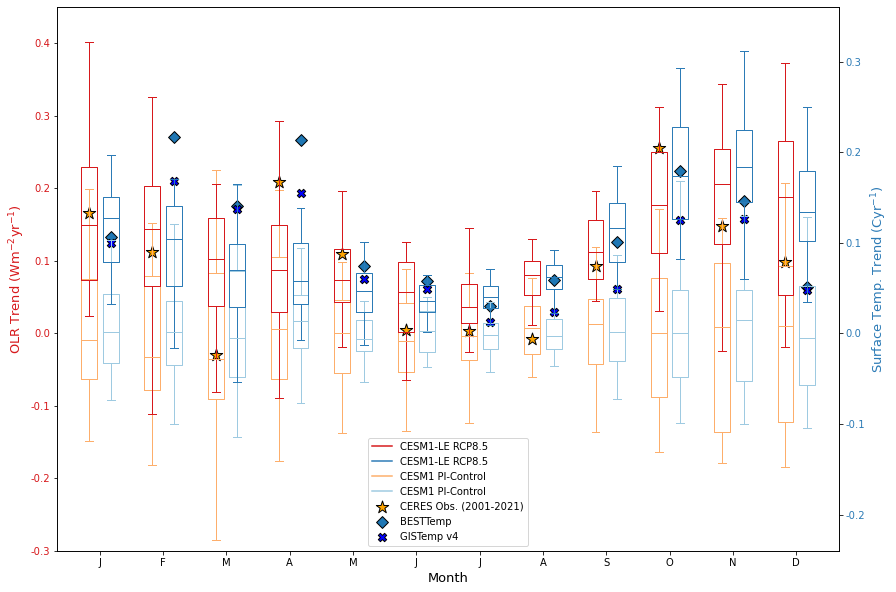

In [129]:
# Raw timeseries data
lens_tseries_olr = allens_var_dict['FLUT']
obs_tseries_olr  = ceres_subset_spatavg

lens_tseries_ts = allens_var_dict['TS']
obs_tseries_ts1  = besttemp_subset_spatavg #1 is Berkeley Best Estimate
obs_tseries_ts2  = gisstemp_subset_spatavg #2 is NASA GIStemp
# obs_tseries_ts_besttemp  = hadsst_subset_spatavg # doesn't work (not enough data in the Arctic)

# Calculate PI-Control timeseries
pic_tseries_olr_2001_2021 = pi_tseries_to_ens(pic_var_dict,tlength=21,nmembers=40)['FLUT']
pic_tseries_ts_2001_2021  = pi_tseries_to_ens(pic_var_dict,tlength=21,nmembers=40)['TS']

tsel_2001_2021 = slice('2001-01-01','2021-12-31')

lens_tseries_olr_2001_2021 = lens_tseries_olr.sel(time=tsel_2001_2021)
obs_tseries_olr_2001_2021 = obs_tseries_olr.sel(time=tsel_2001_2021)

lens_tseries_ts_2001_2021 = lens_tseries_ts.sel(time=tsel_2001_2021)
obs_tseries_ts1_2001_2021  = obs_tseries_ts1.sel(time=tsel_2001_2021)
obs_tseries_ts2_2001_2021  = obs_tseries_ts2.sel(time=tsel_2001_2021)

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
box_fig,box_ax_olr = plt.subplots(1,1,figsize=(14,10)) # create your own axis if not supplied
box_ax_ts = box_ax_olr.twinx()

obs_slopes_olr_2001_2021  = []
lens_slopes_olr_2001_2021 = {}
pic_slopes_olr_2001_2021  = {}

obs_slopes_ts1_2001_2021  = []
obs_slopes_ts2_2001_2021  = []
lens_slopes_ts_2001_2021 = {}
pic_slopes_ts_2001_2021  = {}

# Run a linear fit for each month for each ensemble member
lens_slopes_olr_2001_2021 = get_monthly_slopes(lens_tseries_olr_2001_2021)
pic_slopes_olr_2001_2021  = get_monthly_slopes(pic_tseries_olr_2001_2021)
obs_slopes_olr_2001_2021  = get_monthly_slopes(obs_tseries_olr_2001_2021)

lens_slopes_ts_2001_2021 = get_monthly_slopes(lens_tseries_ts_2001_2021)
pic_slopes_ts_2001_2021  = get_monthly_slopes(pic_tseries_ts_2001_2021)
obs_slopes_ts1_2001_2021  = get_monthly_slopes(obs_tseries_ts1_2001_2021)
obs_slopes_ts2_2001_2021  = get_monthly_slopes(obs_tseries_ts2_2001_2021)

# Plot the model distributions as boxplots
widths = 0.25 # 0.3
offset = 0.17 # 0.25
# Start with PI-Control
box_pic_olr_2001_2021 = box_ax_olr.boxplot(pic_slopes_olr_2001_2021, positions=np.arange(1,13)-offset,widths=widths,whis=(5,95),showfliers=False)
box_pic_ts_2001_2021  = box_ax_ts.boxplot(pic_slopes_ts_2001_2021,  positions=np.arange(1,13)+offset,widths=widths,whis=(5,95),showfliers=False)

set_box_color(box_pic_olr_2001_2021,'#FDAE6B')
set_box_color(box_pic_ts_2001_2021, '#9ECAE1')

# Now do RCP8.5
box_lens_olr_2001_2021 = box_ax_olr.boxplot(lens_slopes_olr_2001_2021, positions=np.arange(1,13)-offset,widths=widths,whis=(5,95),showfliers=False)
box_lens_ts_2001_2021  = box_ax_ts.boxplot(lens_slopes_ts_2001_2021,  positions=np.arange(1,13)+offset,widths=widths,whis=(5,95),showfliers=False)

set_box_color(box_lens_olr_2001_2021, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(box_lens_ts_2001_2021,  '#2C7BB6')

# Plot observations as a scatterplot
# OLR from CERES
box_ax_olr.scatter(np.arange(1,13,1)-offset,obs_slopes_olr_2001_2021,label='CERES Obs. (2001-2021)',marker='*',color='orange',edgecolors= "black",s=170) # update label here
# TS from BESTTEMP and GIStemp
box_ax_ts.scatter(np.arange(1,13,1)+offset,obs_slopes_ts1_2001_2021,label='BESTTemp Obs. (2001-2021)',marker='D',color=None,edgecolors= "black",s=70) # update label here
box_ax_ts.scatter(np.arange(1,13,1)+offset,obs_slopes_ts2_2001_2021,label='GISTemp v4 Obs. (2001-2021)',marker='X',color='blue',edgecolors= "black",s=70) # update label here

box_ax_olr.set_xlabel('Month',fontsize=13)
box_ax_olr.set_ylabel('OLR Trend (Wm$^{-2}$yr$^{-1}$)',fontsize=13,color='#D7191C') # fix 
box_ax_ts.set_ylabel('Surface Temp. Trend (Cyr$^{-1}$)',fontsize=13,color='#2C7BB6')

# box_ax_olr.set_yticklabels(box_ax_olr.get_yticklabels(),color='#D7191C')
# box_ax_ts.set_yticklabels(box_ax_ts.get_yticklabels(),color='#2C7BB6')

box_ax_olr.set_xticks(np.arange(1,13,1))
box_ax_olr.set_xticklabels(month_labels)

box_ax_olr.set_ylim((-0.3,0.45))
box_ax_ts.set_ylim((-0.24,0.36))

box_ax_olr.set_yticklabels(tick_function3(np.arange(-0.3,0.41,0.1)),color='#D7191C')
box_ax_ts.set_yticklabels(tick_function3(np.arange(-0.3,0.31,0.1)),color='#2C7BB6') # not sure why this need to be like this...

# draw temporary red and blue lines and use them to create a legend # use the same axis for all
box_ax_olr.plot([], c='#D7191C', label='CESM1-LE RCP8.5')
box_ax_olr.plot([], c='#2C7BB6', label='CESM1-LE RCP8.5')

box_ax_olr.plot([], c='#FDAE6B', label='CESM1 PI-Control') 
box_ax_olr.plot([], c='#9ECAE1', label='CESM1 PI-Control')

box_ax_olr.scatter([],[],label='BESTTemp',marker='D',color=None,edgecolors= "black",s=70)
box_ax_olr.scatter([],[],label='GISTemp v4',marker='X',color='blue',edgecolors= "black",s=70)

box_ax_olr.legend()

In [130]:
to_png(box_fig,'OLR_TS_LEN_obs_monthlycomparison')

FLUT
TS
FLUT
TS


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator


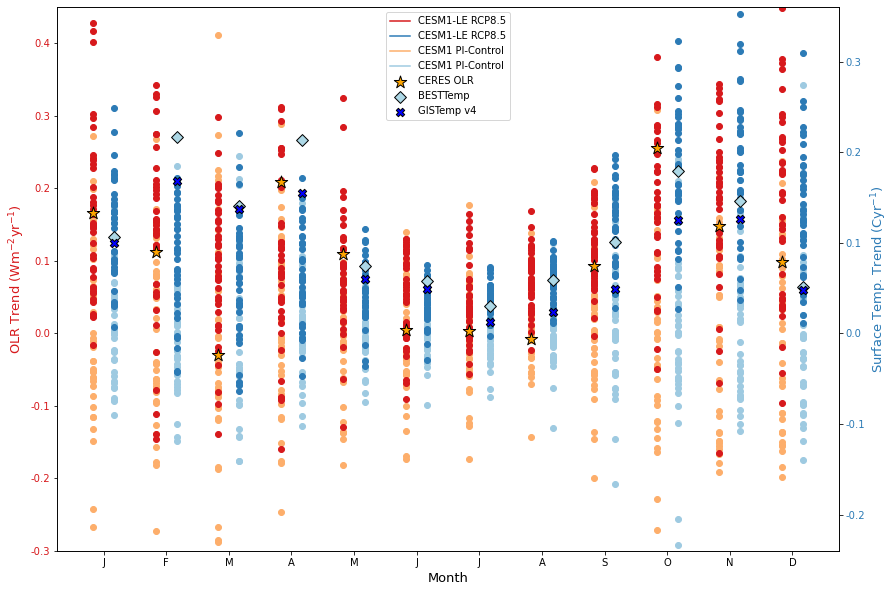

In [139]:
# Raw timeseries data
lens_tseries_olr = allens_var_dict['FLUT']
obs_tseries_olr  = ceres_subset_spatavg

lens_tseries_ts = allens_var_dict['TS']
obs_tseries_ts1  = besttemp_subset_spatavg #1 is Berkeley Best Estimate
obs_tseries_ts2  = gisstemp_subset_spatavg #2 is NASA GIStemp
# obs_tseries_ts_besttemp  = hadsst_subset_spatavg # doesn't work (not enough data in the Arctic)

# Calculate PI-Control timeseries
pic_tseries_olr_2001_2021 = pi_tseries_to_ens(pic_var_dict,tlength=21,nmembers=40)['FLUT']
pic_tseries_ts_2001_2021  = pi_tseries_to_ens(pic_var_dict,tlength=21,nmembers=40)['TS']

tsel_2001_2021 = slice('2001-01-01','2021-12-31')

lens_tseries_olr_2001_2021 = lens_tseries_olr.sel(time=tsel_2001_2021)
obs_tseries_olr_2001_2021 = obs_tseries_olr.sel(time=tsel_2001_2021)

lens_tseries_ts_2001_2021 = lens_tseries_ts.sel(time=tsel_2001_2021)
obs_tseries_ts1_2001_2021  = obs_tseries_ts1.sel(time=tsel_2001_2021)
obs_tseries_ts2_2001_2021  = obs_tseries_ts2.sel(time=tsel_2001_2021)

month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
    
box_fig,box_ax_olr = plt.subplots(1,1,figsize=(14,10)) # create your own axis if not supplied
box_ax_ts = box_ax_olr.twinx()

obs_slopes_olr_2001_2021  = []
lens_slopes_olr_2001_2021 = {}
pic_slopes_olr_2001_2021  = {}

obs_slopes_ts1_2001_2021  = []
obs_slopes_ts2_2001_2021  = []
lens_slopes_ts_2001_2021 = {}
pic_slopes_ts_2001_2021  = {}

# Run a linear fit for each month for each ensemble member
lens_slopes_olr_2001_2021 = get_monthly_slopes(lens_tseries_olr_2001_2021)
pic_slopes_olr_2001_2021  = get_monthly_slopes(pic_tseries_olr_2001_2021)
obs_slopes_olr_2001_2021  = get_monthly_slopes(obs_tseries_olr_2001_2021)

lens_slopes_ts_2001_2021 = get_monthly_slopes(lens_tseries_ts_2001_2021)
pic_slopes_ts_2001_2021  = get_monthly_slopes(pic_tseries_ts_2001_2021)
obs_slopes_ts1_2001_2021  = get_monthly_slopes(obs_tseries_ts1_2001_2021)
obs_slopes_ts2_2001_2021  = get_monthly_slopes(obs_tseries_ts2_2001_2021)

# Plot the model distributions as boxplots
widths = 0.25 # 0.3
offset = 0.17 # 0.25

# Start with PI-Control
for _slopes_olr,_slopes_ts,_xloc_olr,_xloc_ts in zip(pic_slopes_olr_2001_2021,
                                                     pic_slopes_ts_2001_2021,
                                                     np.arange(1,13)-offset,
                                                     np.arange(1,13)+offset):
    
    box_ax_olr.scatter(x=_xloc_olr*np.ones(len(_slopes_olr)),y=_slopes_olr,color='#FDAE6B')
    box_ax_ts.scatter(x=_xloc_ts*np.ones(len(_slopes_ts)),y=_slopes_ts,color='#9ECAE1')

# Now do RCP8.5
for _slopes_olr,_slopes_ts,_xloc_olr,_xloc_ts in zip(lens_slopes_olr_2001_2021,
                                                     lens_slopes_ts_2001_2021,
                                                     np.arange(1,13)-offset,
                                                     np.arange(1,13)+offset):
    
    box_ax_olr.scatter(x=_xloc_olr*np.ones(len(_slopes_olr)),y=_slopes_olr,color='#D7191C')
    box_ax_ts.scatter(x=_xloc_ts*np.ones(len(_slopes_ts)),y=_slopes_ts,color='#2C7BB6')

# Plot observations as a scatterplot
# OLR from CERES
box_ax_olr.scatter(np.arange(1,13,1)-offset,obs_slopes_olr_2001_2021,label='CERES OLR',marker='*',color='orange',edgecolors= "black",s=170) # update label here
# TS from BESTTEMP and GIStemp
box_ax_ts.scatter(np.arange(1,13,1)+offset,obs_slopes_ts1_2001_2021,label='BESTTemp Obs. (2001-2021)',marker='D',color='lightblue',edgecolors= "black",s=70) # update label here
box_ax_ts.scatter(np.arange(1,13,1)+offset,obs_slopes_ts2_2001_2021,label='GISTemp v4 Obs. (2001-2021)',marker='X',color='blue',edgecolors= "black",s=70) # update label here

box_ax_olr.set_xlabel('Month',fontsize=13)
box_ax_olr.set_ylabel('OLR Trend (Wm$^{-2}$yr$^{-1}$)',fontsize=13,color='#D7191C') # fix 
box_ax_ts.set_ylabel('Surface Temp. Trend (Cyr$^{-1}$)',fontsize=13,color='#2C7BB6')

box_ax_olr.set_xticks(np.arange(1,13,1))
box_ax_olr.set_xticklabels(month_labels)

box_ax_olr.set_ylim((-0.3,0.45))
box_ax_ts.set_ylim((-0.24,0.36))

box_ax_olr.set_yticklabels(tick_function3(np.arange(-0.3,0.41,0.1)),color='#D7191C')
box_ax_ts.set_yticklabels(tick_function3(np.arange(-0.3,0.31,0.1)),color='#2C7BB6') # not sure why this need to be like this...

# draw temporary red and blue lines and use them to create a legend # use the same axis for all
box_ax_olr.plot([], c='#D7191C', label='CESM1-LE RCP8.5')
box_ax_olr.plot([], c='#2C7BB6', label='CESM1-LE RCP8.5')

box_ax_olr.plot([], c='#FDAE6B', label='CESM1 PI-Control') 
box_ax_olr.plot([], c='#9ECAE1', label='CESM1 PI-Control')

box_ax_olr.scatter([],[],label='BESTTemp',marker='D',color='lightblue',edgecolors= "black",s=70)
box_ax_olr.scatter([],[],label='GISTemp v4',marker='X',color='blue',edgecolors= "black",s=70)

box_ax_olr.legend()

No, this is definitely worse!

### Show multiple cases on a single plot

### Shrink dimensionality, demonstrate detection disadvantages of OLR

Iterate over period durations one year at a time. Compute a 5th and 95th percentile confidence interval on the trend show in the ensemble for both the forced and pre-industrial simulatons. Define "possibility of detection" as occuring when the 5% confidence interval in the forced ensemble exceeds the 95% confidence interval from the PI-Control ensemble. Compute the "POD" for all months of the year for OLR and TS. Compare results to understand the disadvantages of trying to detect changes in the Arctic from space vs. from the surface.

To-do later:
- Why 5th and 95th percentiles? Is there a clear mathematical reason we can give for this? i.e. Assume a gaussian distribution and talk about two distribution being statistically different. Q: When are two normal distributions (characterized by a mean and std. dev.) statistically different?
- Incorporate some simple measure of observational uncertainty. i.e. If OLR obs. are better than TS obs., how much does this narrow the detection gap?

__One option is to compare the distributions using this approach:__  
The problem is that is comparing the distribution means, and I don't think we want to do that. We know the means are going to be different, but are more interested in their overlap.

Because the sample sizes are small ($<30$), we use the t-statistic for comparing two samples (Barnes Eq. 106)  

$$ t = \frac{(\overline{x_1} - \overline{x_2}) - \Delta_{1,2}}{\hat{\sigma}\sqrt{\frac{1}{N_1}+\frac{1}{N_2}}}, $$

where the pooled variance $\hat{\sigma}$ is given by (Barnes Eq. 107):

$$ \hat{\sigma} = \sqrt{\frac{N_1 s_1^2 + N_2 s_2^2}{N_1 + N_2 -2}} $$

Calculating confidence intervals with a t-statistic:  

$$ \mu = \overline{x} \pm t_{\alpha/2} \frac{s}{\sqrt{N - 1}}. $$

The just requires know the sample mean, standard deviation, sample size, and a desired confidence interval.

Technical to-do's:
- Write functions to calculate a confidence interval using both a bootstrapping method and students t-test approach
- Write wrapper code to iterate over years and store confidence intervals
- Write evaluation/plotting code to give detection durations/differencesWrite wrapper code to iterate over years and store confidence intervals

__Write functions to calculate a confidence interval using both a bootstrapping method and students t-test approach.__

In [ ]:
for i in range(1,nbootstraps): # bootstrap, calculating percentiles
            # resample with replacement
            resample_slopes = np.random.choice(_slopes, N_ens, replace=True)
            # Compute the test statistic from the resampled data
            lower_percentile.append(np.percentile(resample_slopes,100*(alpha/2)))
            upper_percentile.append(np.percentile(resample_slopes,100*(1-alpha/2)))
        
        _lower_bnd_bstrap = np.mean(lower_percentile) # take the mean percentile
        _upper_bnd_bstrap = np.mean(upper_percentile)

In [255]:
def bootstrap_CI(data,percentile,N_bootstraps=1000,size=None):
    '''
    Function to compute a percentile from a distribution using bootstrapping.
    '''
    if size is None: # Default is to use the sample size as the bootstrapping length (requires replacement)
        size = len(data)
    
    # Generate a list of bootstrapped means by sampling with replacement
    bootstrap_statistic = [np.random.choice(data,size=size,replace=True).mean() for i in range(N_bootstraps)] 
    
    return np.percentile(bootstrap_statistic, percentile) # calculate the requested percentile and return


def bootstrap_CI2(data,percentile,N_bootstraps=1000,size=None):
    '''
    Function to compute a percentile from a distribution using bootstrapping.
    '''
    if size is None: # Default is to use the sample size as the bootstrapping length (requires replacement)
        size = len(data)
    
    # Generate a list of bootstrapped means by sampling with replacement
    bootstrap_statistic = [np.percentile(np.random.choice(data,size=size,replace=True),percentile) for i in range(N_bootstraps)] 
    
    return np.mean(bootstrap_statistic) # calculate the requested percentile and return


def bootstrap_detection(data,low_bnd,hgh_bnd,N_bootstraps=1000,size=None):
    '''
    Function to evaluate the fraction of data outside of supplied confidence interval (low_bnd,hgh_bnd) using bootstrapping.
    '''
    if (low_bnd > hgh_bnd).any(): # catch a classic error
        print('Lower bound supplied to function "bootstrap_detection()" exceeds upper bound. Exiting...')
        return None
    
    if size is None: # Default is to use the sample size as the bootstrapping length (requires replacement)
        size = len(data)
    
    # Generate a list of bootstrapped means by sampling with replacement
    detections = []
    for i in range(N_bootstraps): # I don't think that I can do this in a single line (i.e. with list comprehension) shouldn't slow it down though
        _sample = np.random.choice(data,size=size,replace=True)
        _num_detect = np.sum(np.bitwise_or(_sample<low_bnd.values, _sample>hgh_bnd.values)) # sum up the true values
        # _frac_detection = _num_detect / size
        detections.append(_num_detect)
    # print(_num_detect)        
    return np.mean(detections)/size # calculate the requested percentile and return


def ttest_CI(data,percentile):
    '''
    Function to compute a percentile from a distribution using a standard student's t-test.
    $$ \mu = \overline{x} \pm t_{\alpha/2} \frac{s}{\sqrt{N - 1}}. $$    
    '''
    
    data_mean = np.mean(data)
    data_std  = np.std(data)
    data_N    = len(data)
    
    alpha = percentile / 100 # assume the percentile is given as a percentage
    t_val = stats.t.ppf(alpha,data_N-1)
    
    CI_value = data_mean + t_val * data_std / np.sqrt(data_N-1)
    
    return CI_value


def calc_CI(data,percentile,method='ttest',**kwargs):
    '''
    Wrapper function for two different percentile calculating functions. Default to the student's t-test.
    '''
    if method=='ttest':
        return ttest_CI(data,percentile)
    elif method=='bootstrap':
        return bootstrap_CI2(data,percentile,**kwargs)
    elif method=='bootstrap_detect':
        return bootstrap_detection(data,*percentile,**kwargs) # not sure if this implementation will work...
    else:
        print('Method must be "ttest" or "bootstrap"')
        return None

# Vectorize the calc_CI function to save space later on for loops
calc_CI_vec = np.vectorize(calc_CI,excluded=['percentile','method','ens'],signature='(m)->()') # the signature input does not make sense to me yet...
# excluded=['percentile','method'],

bootstrap_detection_vec = np.vectorize(bootstrap_detection,excluded=['method'],signature='(m)->()') # this function needs to be vectorized differently so it can't go in calc_CI
    
def standardize_data(data):
    '''Standardize data. A rather useless wrapper perhaps.'''
    return (data - np.mean(data)) / np.std(data)

__Write wrapper code to iterate over years and store confidence intervals.__

In [421]:
# def get_CI_byyear(data,firstyear,first_endyear,last_endyear):
def get_CI_byyear(data,trend_duration_min_yrs,trend_duration_max_yrs,CI_percentile,CI_method='ttest',add_annual=False,**kwargs):
    '''Code will iterate over years and calculate a constant confidence interval. Return a dictionary keyed by the endyear?'''
    
    CI_dict = {}
    CI_list = []
    
    # Iterate over trend durations, slicing with isel
    for _tot_yrs in range(trend_duration_min_yrs,trend_duration_max_yrs+1):
        
        _time_subset = data.isel(time=slice(None,_tot_yrs*12)) # assume monthly resolution
        _subset_slopes = get_monthly_slopes(_time_subset,add_annual=add_annual) # calculate the monthly slopes for this period
        
        # Call our vectorized confidence interval function with the appropriate method (weirdly requires giving them as kwargs
        endyr_percentiles = calc_CI_vec(_subset_slopes,percentile=CI_percentile,method=CI_method) #,**kwargs)
        
        # Convert back to an xarray object indexed by months
        endyr_percentiles_da = xr.DataArray(
            data=endyr_percentiles,
            dims=['month'],
            coords=dict(
                month=np.arange(1,endyr_percentiles.shape[0]+1),
                # month=np.arange(1,13),
                duration=_tot_yrs,
            ),
            attrs=dict(
                description="%d Percentile Trend for trend of %d years" % (CI_percentile,_tot_yrs),
            ),
        )
        
        # Save in the dictionary to be returned
        CI_dict[str(_tot_yrs)] = endyr_percentiles_da
        CI_list.append(endyr_percentiles_da)
                
    CI_da = xr.concat(CI_list,dim='duration')
        
    return CI_da


def get_detect_byyear(data,low_bnds_da,hgh_bnds_da,trend_duration_min_yrs,trend_duration_max_yrs,add_annual=False):
    '''Code will iterate over years and calculate a constant confidence interval. Return a dictionary keyed by the endyear?'''
        
    CI_list = []

    # Iterate over trend durations, slicing with isel
    for _tot_yrs in range(trend_duration_min_yrs,trend_duration_max_yrs+1):

        # get lower and upper bounds on the unforced data
        low_bnds = low_bnds_da.sel(duration=_tot_yrs)
        hgh_bnds = hgh_bnds_da.sel(duration=_tot_yrs)

        _time_subset = data.isel(time=slice(None,_tot_yrs*12)) # subset the forced data assuming monthly resolution
        _subset_slopes = get_monthly_slopes(_time_subset,add_annual=add_annual) # calculate the monthly slopes for this period

        # Call our vectorized confidence detection method
        frac_detect = []
        # for _mon in range(12):
        for _mon in range(_subset_slopes.shape[0]):
            _subsub_slopes = _subset_slopes.sel(month=_mon+1)
            _low_bnd = low_bnds.sel(month=_mon+1)
            _hgh_bnd = hgh_bnds.sel(month=_mon+1)

            _frac = calc_CI(_subsub_slopes,percentile=(_low_bnd,_hgh_bnd),method='bootstrap_detect') # N_bootstraps=99
            frac_detect.append(_frac)
        frac_detect = np.array(frac_detect)
        # I could not get this to vectorize, but maybe a less tired brain will be able to do this later
        # frac_detect = calc_CI_vec(_subset_slopes,percentile=(low_bnds_T,hgh_bnds_T),method='bootstrap_detect') # need to transpose so vectorization lines up...
        # frac_detect = bootstrap_detection_vec(_subset_slopes,low_bnd=low_bnds,hgh_bnd=hgh_bnds)

        # Convert back to an xarray object indexed by months
        frac_detect_da = xr.DataArray(
            data=frac_detect,
            dims=['month'],
            coords=dict(
                month=np.arange(1,frac_detect.shape[0]+1),
                # month=np.arange(1,13),
                duration=_tot_yrs,
            ),
            attrs=dict(
                description="Fraction of CESM1-LE RCP8.5 model exceeding an unforced response",
            ),
        )

        # Save in the dictionary to be returned
        CI_list.append(frac_detect_da)

    return xr.concat(CI_list,dim='duration')


def get_monthly_slopes(tseries,add_annual=False):
    '''
    Return slopes for each month of the year when passed a timeseries with monthly resolution. 
    Plays well with additional coordinates.
    '''
    
    # Group by month and apply a linear fit. Returned object contains slopes and y-intercepts for each month of the year
    linfit_obj = tseries.groupby('time.month').map(linear_polyfit) # requires my wrapped polyfit function "linear_polyfit"

    slopes = linfit_obj['polyfit_coefficients'].sel(degree=1) # select just the slope (what we're interested in)
    
    if add_annual: # add a 13th month that actually contains the slopes of an annual averaged timeseries
        annual_slopes = tseries.groupby('time.year').mean('time').polyfit('year',deg=1)['polyfit_coefficients'].sel(degree=1)
        new_slopes = xr.concat([slopes,annual_slopes.assign_coords({'month':13})],dim='month')
        return new_slopes
    
    return slopes

#### Apply new functions.

Iterate over period durations one year at a time. Compute a 5th and 95th percentile confidence interval on the trend show in the ensemble for both the forced and pre-industrial simulatons. Define "possibility of detection" as occuring when the 5% confidence interval in the forced ensemble exceeds the 95% confidence interval from the PI-Control ensemble. Compute the "POD" for all months of the year for OLR and TS. Compare results to understand the disadvantages of trying to detect changes in the Arctic from space vs. from the surface.

1. Calculate 95% confidence intervals on the PI-Control simulations
2. Iterate over the 95% confidence interval on the PI-Control simulations and bootstrap the fraction of forced models outside of the  natural variability.

Calculate 95% confidence intervals on the PI-Control simulations

In [ ]:
besttemp_trends_wrapped = xr.concat([besttemp_trends,besttemp_trends[0].assign_coords({'month':13})],dim='month')


In [397]:
olr_pic_975th_10_40 = get_CI_byyear(data=pic_tseries_2001_2025['FLUT'],trend_duration_min_yrs=2,trend_duration_max_yrs=45,CI_percentile=97.5,CI_method='bootstrap',
                                   add_annual=True)
olr_pic_25nd_10_40 = get_CI_byyear(data=pic_tseries_2001_2025['FLUT'],trend_duration_min_yrs=2,trend_duration_max_yrs=45,CI_percentile=2.5,CI_method='bootstrap',
                                  add_annual=True)

ts_pic_975th_10_40 = get_CI_byyear(data=pic_tseries_2001_2025['TS'],trend_duration_min_yrs=2,trend_duration_max_yrs=45,CI_percentile=97.5,CI_method='bootstrap',
                                  add_annual=True)
ts_pic_25nd_10_40 = get_CI_byyear(data=pic_tseries_2001_2025['TS'],trend_duration_min_yrs=2,trend_duration_max_yrs=45,CI_percentile=2.5,CI_method='bootstrap',
                                 add_annual=True)

In [422]:
olr_detect_likelihood = get_detect_byyear(data=allens_var_dict['FLUT'],
                                          low_bnds_da=olr_pic_25nd_10_40,
                                          hgh_bnds_da=olr_pic_975th_10_40,
                                          trend_duration_min_yrs=2,
                                          trend_duration_max_yrs=45,
                                          add_annual=True
                                         )

ts_detect_likelihood  = get_detect_byyear(data=allens_var_dict['TS'],
                                          low_bnds_da=ts_pic_25nd_10_40,
                                          hgh_bnds_da=ts_pic_975th_10_40,
                                          trend_duration_min_yrs=2,
                                          trend_duration_max_yrs=45,
                                          add_annual=True
                                         )

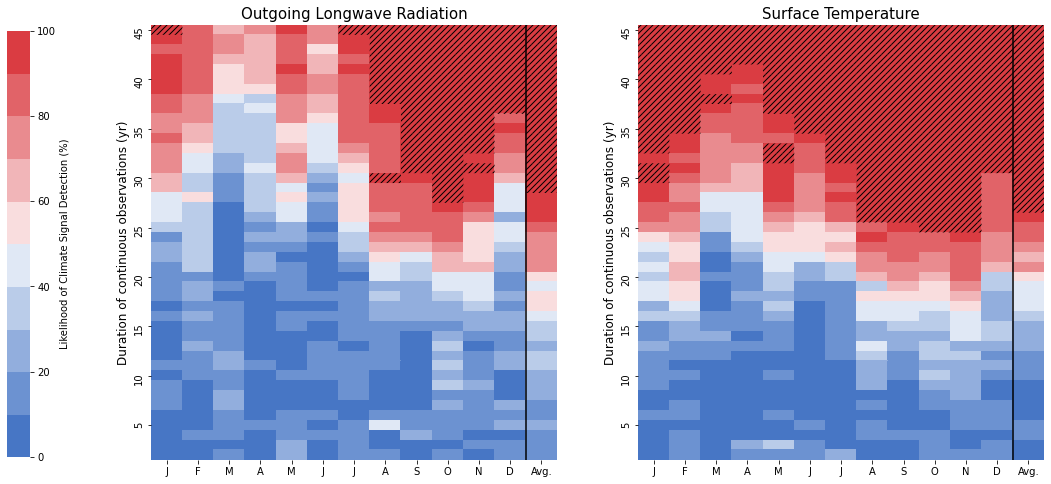

In [429]:
month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','Avg.']
cmap = sns.diverging_palette(h_neg=254,h_pos=11,s=74,l=50,sep=10,n=10,center='light',as_cmap=False) # 'rocket_r'

detect_fig,detect_axs = plt.subplots(nrows=1,ncols=2,figsize=(16,8))
cbar_axh2 = detect_fig.add_axes([0, 0.13, 0.02, 0.74])

olr_detect_data = 100*np.flip(olr_detect_likelihood,axis=0)
ts_detect_data = 100*np.flip(ts_detect_likelihood,axis=0)

im1 = sns.heatmap(olr_detect_data,ax=detect_axs[0],xticklabels=month_labels,cbar=True,cmap=cmap,vmin=0,vmax=100,
                  cbar_ax=cbar_axh2,cbar_kws={'orientation':'vertical','label':'Likelihood of Climate Signal Detection (%)'})

im2 = sns.heatmap(ts_detect_data,ax=detect_axs[1],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100)

zm = olr_detect_data.where(olr_detect_data>95)
x = np.arange(0,olr_detect_data.shape[1]+1)       
y = np.arange(0,olr_detect_data.shape[0]+1)
detect_axs[0].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = ts_detect_data.where(ts_detect_data>95)
x = np.arange(0,ts_detect_data.shape[1]+1)       
y = np.arange(0,ts_detect_data.shape[0]+1)
detect_axs[1].pcolor(x, y, zm, hatch='////', alpha=0.)

detect_axs[0].set_yticks(43 - np.arange(3,46,5)+0.5)
detect_axs[0].set_yticklabels(tick_function1(np.arange(5,46,5)))
detect_axs[0].set_ylabel('Duration of continuous observations (yr)',fontsize=12)
detect_axs[0].set_title('Outgoing Longwave Radiation',fontsize=15)
detect_axs[0].vlines(12,0,45,color='black')

detect_axs[1].set_yticks(43 - np.arange(3,46,5)+0.5)
detect_axs[1].set_yticklabels(tick_function1(np.arange(5,46,5)))
detect_axs[1].set_ylabel('Duration of continuous observations (yr)',fontsize=12)
detect_axs[1].set_title('Surface Temperature',fontsize=15)
detect_axs[1].vlines(12,0,45,color='black')

In [430]:
to_png(detect_fig,'monthly_signal_detection')

In [322]:
sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43026136111758173, 0.6200066482697917, 0.6787801878373952),
 (0.6085255804707219, 0.7412795877319109, 0.7824000973141302),
 (0.786789799823862, 0.86255252719403, 0.8860200067908652),
 (0.95, 0.95, 0.95),
 (0.954577257933482, 0.7665309859226215, 0.7803256889894359),
 (0.9197182699854205, 0.5873587656270927, 0.6117400023569117),
 (0.884859282037359, 0.40818654533156384, 0.4431543157243877),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)]

### Old Code

In [150]:
pic_tseries_2001_2025 = pi_tseries_to_ens(pic_var_dict,tlength=45,nmembers=40)#['FLUT']
# pic_tseries_ts_2001_2025  = pi_tseries_to_ens(pic_var_dict,tlength=25,nmembers=40)['TS']

FLUT
TS


Old approach

In [157]:
olr_ens_5th_10_40  = get_CI_byyear(data=allens_var_dict['FLUT'],trend_duration_min_yrs=2,trend_duration_max_yrs=45,CI_percentile=5,CI_method='bootstrap')
olr_pic_95th_10_40 = get_CI_byyear(data=pic_tseries_2001_2025['FLUT'],trend_duration_min_yrs=2,trend_duration_max_yrs=45,CI_percentile=97.5,CI_method='bootstrap')

In [158]:
ts_ens_5th_10_40  = get_CI_byyear(data=allens_var_dict['TS'],trend_duration_min_yrs=2,trend_duration_max_yrs=45,CI_percentile=5,CI_method='bootstrap')
ts_pic_95th_10_40 = get_CI_byyear(data=pic_tseries_2001_2025['TS'],trend_duration_min_yrs=2,trend_duration_max_yrs=45,CI_percentile=97.5,CI_method='bootstrap')

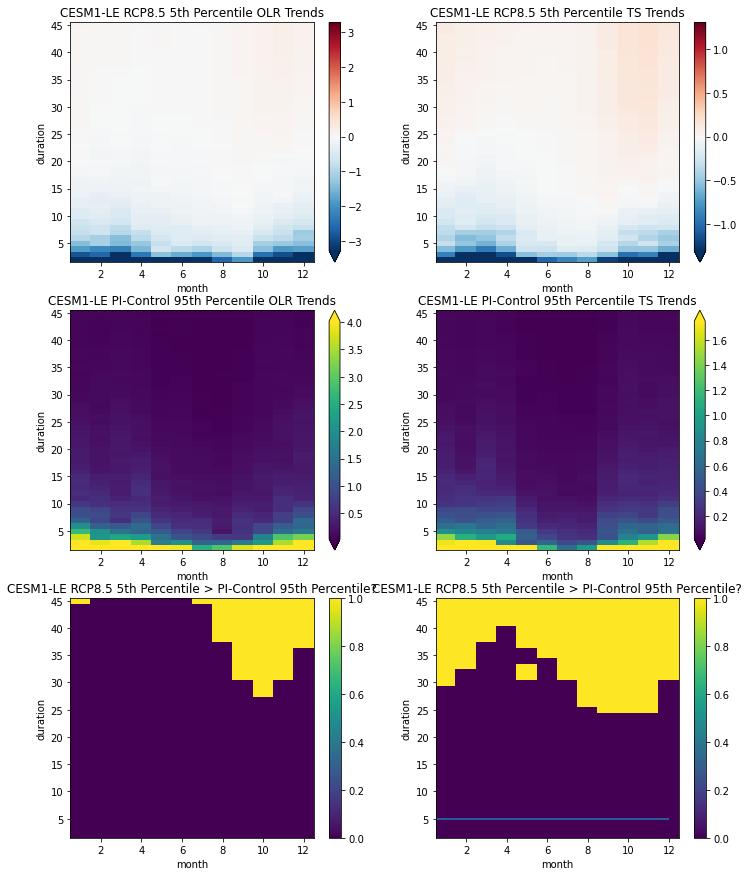

In [163]:
detc_fig,detc_axs = plt.subplots(nrows=3,ncols=2,figsize=(12,15))

olr_ens_5th_10_40.plot(ax=detc_axs[0,0],robust=True)
detc_axs[0,0].set_title('CESM1-LE RCP8.5 5th Percentile OLR Trends')

olr_pic_95th_10_40.plot(ax=detc_axs[1,0],robust=True)
detc_axs[1,0].set_title('CESM1-LE PI-Control 95th Percentile OLR Trends')

(olr_ens_5th_10_40>olr_pic_95th_10_40).plot(ax=detc_axs[2,0])
detc_axs[2,0].set_title('CESM1-LE RCP8.5 5th Percentile > PI-Control 95th Percentile?')

ts_ens_5th_10_40.plot(ax=detc_axs[0,1],robust=True)
detc_axs[0,1].set_title('CESM1-LE RCP8.5 5th Percentile TS Trends')

ts_pic_95th_10_40.plot(ax=detc_axs[1,1],robust=True)
detc_axs[1,1].set_title('CESM1-LE PI-Control 95th Percentile TS Trends')

(ts_ens_5th_10_40>ts_pic_95th_10_40).plot(ax=detc_axs[2,1])
detc_axs[2,1].set_title('CESM1-LE RCP8.5 5th Percentile > PI-Control 95th Percentile?')

# detc_axs[2,1].hlines(5,0,12)

This would be more useful if instead of giving us a binary detected or not detected value, it gave us the probability of detection. I can do this by bootstrapping a 95% confidence interval on the unforced response, and then bootstrapping the fraction of ensemble members above/below that confidence interval for each year. The probability of detection is just the fraction of ensemble members outside of the natural variability confidence interval. 
- This doesn't consider ensemble members on the edge that may be detectable one year and then not detectable the next, but this is a slightly different definition from the emergence plots (that was binary and didn't consider probabilities), so I think that is ok.

# Old Dask stuff that didn't work

https://docs.dask.org/en/latest/delayed-best-practices.html

"working?" Dask approach. Breaks when I actually run it with multiple workers.

In [33]:
# %%time

# @dask.delayed
# def load_ens(path_dict,_ens_num):
    
#     _ens_olr_files = path_dict[_ens_num]
#     _ens_olr_ds = fix_cesm_time(xr.open_mfdataset(_ens_olr_files))['FLUT'].chunk({'lat':-1,'lon':-1}) # chunk to prep for lat-lon interpolation
#     # ^is this bad that I am opening a dask object within a .delayed call? No?
    
#     return _ens_olr_ds

# @dask.delayed
# def process_ens(_ens_olr_ds,_interp_latlon):
    
#     _ens_interp = _ens_olr_ds.interp_like(_interp_latlon.isel(time=0)) # interpolate before subsetting, could use xESMF
#     _ens_olr_ds.close()
#     _ens_subset = _ens_interp.sel(time=slice('2001-01-01','2021-12-31'),lat=slice(69,None))
#     _ens_subset.close()
#     _ens_subset_wgtd = add_weights(_ens_subset) # add area-weighting coordinate
#     _ens_subset.close()
#     _ens_subset_spatavg = masked_average(_ens_subset_wgtd,dim=['lat','lon'],weights=_ens_subset_wgtd['cell_weight'])
#     _ens_subset_wgtd.close()
    
#     return _ens_subset_spatavg

# @dask.delayed
# def compute_ens(_ens_subset_spatavg,_ens_num):
    
#     _ens_subset_jfm = _ens_subset_spatavg.sel(time=is_jfm(_ens_subset_spatavg.time)) # select jan, feb, mar
#     _ens_subset_ond = _ens_subset_spatavg.sel(time=is_ond(_ens_subset_spatavg.time)) # select jan, feb, mar
#     _ens_subset_jfmavg = _ens_subset_jfm.groupby('time.year').mean('time') #.compute() # average into an annual timeseries, compute to avoid chunkng
#     _ens_subset_ondavg = _ens_subset_ond.groupby('time.year').mean('time') #.compute() # average into an annual timeseries, compute to avoid chunkng
#     _ens_subset_jfm.close()
#     _ens_subset_ond.close()
#     _ens_subset_monavg = _ens_subset_spatavg.groupby('time.month').mean('time') #.compute() # monthly OLR averages over the CERES record
#     _ens_subset_spatavg.close()
    
#     _ens_subset_jfmavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
#     _ens_subset_ondavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
#     _ens_subset_monavg['ens'] = int(_ens_num) # add ensemble coordinate for easy combining
    
#     return _ens_subset_jfmavg,_ens_subset_monavg,_ens_subset_ondavg

# def f(path_dict,ensemble_nums):
#     # results = []
#     results = {}
#     for _ens_num in ensemble_nums:
#         # print(_ens_num)
#         data = load_ens(path_dict,_ens_num)
#         data = process_ens(data,ceres_subset)
#         result = compute_ens(data,_ens_num)

#         # results.append(result)
#         results[_ens_num] = result
        
#         # if _ens_num == '005':break

#     return results

In [34]:
# %%time

# preresults = f(path_dict,ensemble_nums)

In [35]:
# %%time

# results = dask.compute(preresults)[0]

#### Post-process into a ensemble-combined format

Only do if the dask approach is fixed.

In [36]:
ens_olr_jfm_tseries_list = []
ens_olr_ond_tseries_list = []
ens_olr_mon_tseries_list = []

for _ens_num in ensemble_nums:
    ens_olr_jfm_tseries_list.append(results[_ens_num][0])
    ens_olr_ond_tseries_list.append(results[_ens_num][0])
    ens_olr_mon_tseries_list.append(results[_ens_num][1])
    
allens_jfm_tseries = xr.concat(ens_olr_jfm_tseries_list,dim='ens') #.chunk({'year':-1,'ens':-1})
allens_ond_tseries = xr.concat(ens_olr_ond_tseries_list,dim='ens') #.chunk({'year':-1,'ens':-1})
allens_mon_tseries = xr.concat(ens_olr_mon_tseries_list,dim='ens') #.chunk({'year':-1,'ens':-1})

NameError: name 'results' is not defined

In [ ]:
allens_jfm_tseries = xr.concat(list(ens_olr_jfm_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})
allens_ond_tseries = xr.concat(list(ens_olr_ond_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})
allens_mon_tseries = xr.concat(list(ens_olr_mon_tseries_dict.values()),dim='ens') #.chunk({'year':-1,'ens':-1})